In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import joblib
import urllib.request
from datetime import datetime, timedelta, date
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (15, 5)
import altair as alt
import streamlit as st
import statsmodels.api as sm

In [15]:
countries = "'Australia','Canada','China','Denmark','Finland','France','Germany','India','Indonesia','Italy','Japan','Malaysia','Mexico','Norway','Philippines','Saudi Arabia','Singapore','Spain','Sweden','Taiwan','Thailand','United Arab Emirates','United Kingdom','United States','Vietnam'"

In [17]:
countries.replace(',', ', ')

"'Australia', 'Canada', 'China', 'Denmark', 'Finland', 'France', 'Germany', 'India', 'Indonesia', 'Italy', 'Japan', 'Malaysia', 'Mexico', 'Norway', 'Philippines', 'Saudi Arabia', 'Singapore', 'Spain', 'Sweden', 'Taiwan', 'Thailand', 'United Arab Emirates', 'United Kingdom', 'United States', 'Vietnam'"

In [2]:
variable = 'new_cases_'
initialdate = '2020-01-01'   # first day of the year, where most of our data starts
# moving intialdate by 6, since we later apply 7-day rolling mean to our data:
initialdateshift = str(date.fromordinal(datetime.strptime(initialdate, '%Y-%m-%d').toordinal() + 6)) 
#enddate = str(date.fromordinal(date.today().toordinal()-1))   # yesterday's date: last day of available data

country = 'Denmark'
col = variable + country
url1 = 'https://raw.githubusercontent.com/martaarozarena/KSchool-Master-Final-Project/master/data/endogenous.csv'
covid_ctry_varR = pd.read_csv(url1, parse_dates=['date'], index_col=['date'], usecols=['date', col])

In [3]:
url2 = 'https://raw.githubusercontent.com/martaarozarena/KSchool-Master-Final-Project/master/data/exogenous.csv'
exog = pd.read_csv(url2, parse_dates=['date'], index_col=['date'])
exog = exog.loc[:, exog.columns.str.contains(country)]

In [4]:
enddate = str(date.fromordinal(covid_ctry_varR.tail(1).index[0].toordinal())) # last day of available data
enddate

'2020-09-22'

In [6]:
exog.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-09-13', '2020-09-14', '2020-09-15', '2020-09-16',
               '2020-09-17', '2020-09-18', '2020-09-19', '2020-09-20',
               '2020-09-21', '2020-09-22'],
              dtype='datetime64[ns]', name='date', length=266, freq=None)

In [5]:
exog.iloc[-1, exog.columns.str.contains('Testing|Contact')]

H2_Testing policy_Denmark     3.0
H3_Contact tracing_Denmark    2.0
Name: 2020-09-21 00:00:00, dtype: float64

In [7]:
last_test_value = exog.iloc[-1, exog.columns.str.contains('Testing|Contact')][0]
int(last_test_value)

3

In [8]:
last_contact_value = exog.iloc[-1, exog.columns.str.contains('Testing|Contact')][1]
last_contact_value

2.0

In [9]:
exog.columns

Index(['positive_rate_Denmark', 'C1_School closing_Denmark',
       'C2_Workplace closing_Denmark', 'C3_Cancel public events_Denmark',
       'C4_Restrictions on gatherings_Denmark',
       'C5_Close public transport_Denmark',
       'C6_Stay at home requirements_Denmark',
       'C7_Restrictions on internal movement_Denmark',
       'C8_International travel controls_Denmark',
       'H1_Public information campaigns_Denmark', 'H2_Testing policy_Denmark',
       'H3_Contact tracing_Denmark', 'mask_Denmark', 'flightsArr_Denmark'],
      dtype='object')

In [10]:
forecastdays = 14
new_begin = str(date.fromordinal(datetime.strptime(enddate, '%Y-%m-%d').toordinal() + 1))
new_date = str(date.fromordinal(datetime.strptime(enddate, '%Y-%m-%d').toordinal() + forecastdays))
new_index = pd.date_range(initialdate, new_date, freq='D')
exog_futur = exog.reindex(new_index).interpolate()

In [11]:
exog_futur.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2020-09-27', '2020-09-28', '2020-09-29', '2020-09-30',
               '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-04',
               '2020-10-05', '2020-10-06'],
              dtype='datetime64[ns]', length=280, freq='D')

<AxesSubplot:>

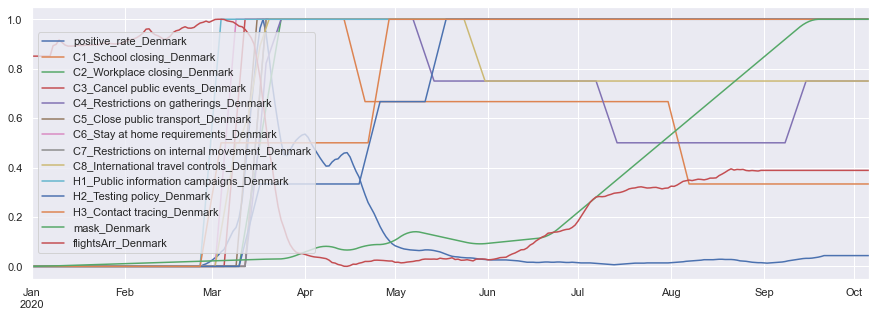

In [12]:
sc_in_fc = MinMaxScaler(feature_range=(0, 1))
scaled_input_fc = sc_in_fc.fit_transform(exog_futur)
scaled_input_fc = pd.DataFrame(scaled_input_fc, index=exog_futur.index, columns=exog_futur.columns)
X_fc = scaled_input_fc
X_fc.plot()

In [13]:
url3 = 'https://github.com/martaarozarena/KSchool-Master-Final-Project/raw/master/models/' + country.replace(" ", "") + '_' + variable + 'model.pkl'
model = joblib.load(urllib.request.urlopen(url3))

<AxesSubplot:xlabel='date'>

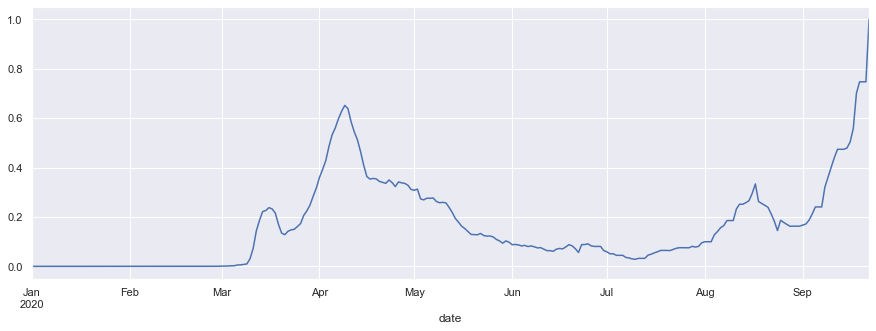

In [14]:
sc_out = MinMaxScaler(feature_range=(0, 1))
scaled_output = sc_out.fit_transform(covid_ctry_varR)
scaled_output  = pd.Series(scaled_output.flatten(), index=covid_ctry_varR.index, name=covid_ctry_varR.columns[0])
scaled_output.plot()

In [ ]:
scaled_output.name

In [15]:
past_rs = covid_ctry_varR.reset_index()

In [16]:
results = model.get_forecast(steps=14, exog=X_fc[new_begin:new_date])
mean_forecast = results.predicted_mean

forecast14 = sc_out.inverse_transform(mean_forecast.values.reshape(-1,1))
forecast14S = pd.Series(forecast14.flatten(), index=mean_forecast.index, name='new_cases_forecast')
future_rs = forecast14S.to_frame().reset_index()

In [17]:
# Get confidence intervals of  predictions
confidence_intervals = results.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower ' + scaled_output.name]
upper_limits = confidence_intervals.loc[:,'upper ' + scaled_output.name]

forecast14_ll = sc_out.inverse_transform(lower_limits.values.reshape(-1,1))
forecast14_llS = pd.Series(forecast14_ll.flatten(), index=lower_limits.index, name='new_cases_forecast_ll')
fcast_ll_df = forecast14_llS.to_frame().reset_index()

forecast14_ul = sc_out.inverse_transform(upper_limits.values.reshape(-1,1))
forecast14_ulS = pd.Series(forecast14_ul.flatten(), index=upper_limits.index, name='new_cases_forecast_ul')
fcast_ul_df = forecast14_ulS.to_frame().reset_index()

In [18]:
confidence_intervals

,lower new_cases_Denmark,upper new_cases_Denmark
2020-09-23,1.140810,1.180323
2020-09-24,1.193591,1.270136
2020-09-25,1.274813,1.387584
2020-09-26,1.436472,1.591396
2020-09-27,1.611806,1.820292
2020-09-28,1.727343,1.998199
2020-09-29,1.799074,2.134961
2020-09-30,1.892520,2.294325
2020-10-01,2.028187,2.499552
2020-10-02,2.165358,2.712287


In [19]:
conf_int = pd.concat([fcast_ll_df, fcast_ul_df.iloc[:, 1]], axis=1)
conf_int

,index,new_cases_forecast_ll,new_cases_forecast_ul
0,2020-09-23,574.153166,594.039651
1,2020-09-24,600.717519,639.241284
2,2020-09-25,641.594945,698.351444
3,2020-09-26,722.956032,800.926674
4,2020-09-27,811.198909,916.127013
5,2020-09-28,869.347207,1005.664870
6,2020-09-29,905.448199,1074.495207
7,2020-09-30,952.478264,1154.700923
8,2020-10-01,1020.757628,1257.988752
9,2020-10-02,1089.793659,1365.055259


In [22]:
covid_ctry_varR.columns[0]

'new_cases_Denmark'

In [23]:
ttt = forecast14S.head(1).to_frame()
ttt.columns = [covid_ctry_varR.tail(1).columns[0]]
ttt

,new_cases_Denmark
2020-09-22,397.189544


In [24]:
forecast14S.head(1).to_frame().rename(columns={forecast14S.head(1).to_frame().columns[0]:covid_ctry_varR.tail(1).columns[0]})

,new_cases_Denmark
2020-09-22,397.189544


In [20]:
new = pd.concat([covid_ctry_varR.tail(1), forecast14S.head(1).to_frame().rename(columns={forecast14S.head(1).to_frame().columns[0]:covid_ctry_varR.tail(1).columns[0]})])
new_rs = new.reset_index()
new_rs

,index,new_cases_Denmark
0,2020-09-22,503.285714
1,2020-09-23,584.096409


In [21]:
past_plt = alt.Chart(past_rs).mark_line().encode(
    x='date:T',
    y=col,
    tooltip=alt.Tooltip(col, format='.1f')
).properties(
    width=800,
    height=300
).interactive()

In [22]:
test = alt.Chart(new_rs).mark_line(opacity=0.5, size=1.2).encode(
    x='index:T',
    y=col
)

In [23]:
future_plt = alt.Chart(future_rs).mark_line(color='orange').encode(
    x=alt.X('index:T', axis=alt.Axis(title='Date', titleFontWeight='normal', titleAlign='right')),
    y=alt.Y('new_cases_forecast', axis=alt.Axis(title='New coronavirus cases')),
    tooltip=alt.Tooltip('new_cases_forecast', format='.1f')
).properties(
    width=800,
    height=300
).interactive()

In [24]:
confint_plot = alt.Chart(conf_int).mark_area(opacity=0.2, color='orange').encode(
    alt.X('index:T'),
    alt.Y('new_cases_forecast_ll'),
    alt.Y2('new_cases_forecast_ul')
)

In [25]:
past_plt + future_plt + test + confint_plot

alt.LayerChart(...)

In [30]:
confint_plot = alt.Chart(conf_int).mark_area(opacity=0.2, color='orange').encode(
    alt.X('index:T'),
    alt.Y('new_cases_forecast_ll'),
    alt.Y2('new_cases_forecast_ul')
)
confint_plot

alt.Chart(...)

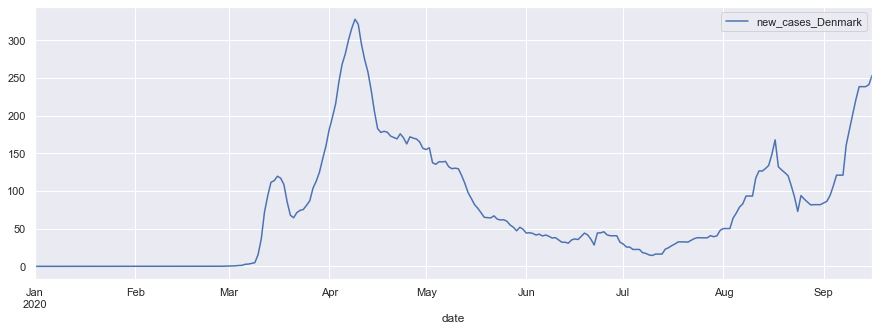

In [31]:
covid_ctry_varR.plot()

In [32]:
future_rs.columns[1]

'new_cases_forecast'

In [33]:
forecast14S_l = ["%.1f" % elem for elem in forecast14S]
print('Next 14 days forecast values: ', forecast14S_l)

Next 14 days forecast values:  ['242.8', '243.5', '243.9', '244.1', '244.2', '244.2', '244.2', '244.2', '244.3', '244.3', '244.3', '244.3', '244.3', '244.3']


In [34]:
future_rs

,index,new_cases_forecast
0,2020-09-16,242.815945
1,2020-09-17,243.509587
2,2020-09-18,243.869846
3,2020-09-19,244.056956
4,2020-09-20,244.154135
5,2020-09-21,244.204608
6,2020-09-22,244.230822
7,2020-09-23,244.244437
8,2020-09-24,244.251509
9,2020-09-25,244.255181


In [35]:
def get_model():
    url3 = 'https://github.com/martaarozarena/KSchool-Master-Final-Project/raw/master/models/' + country +'SARIMAXmodel.pkl'
    smodel = joblib.load(urllib.request.urlopen(url3))
#    smodel = sm.load_pickle('./models_old/SpainSARIMAXmodel_savedWithStatstools.pkl')
    return smodel

model =  get_model()

In [36]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      new_cases_Denmark   No. Observations:                  259
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 627.757
Date:                Thu, 17 Sep 2020   AIC                          -1223.514
Time:                        17:22:35   BIC                          -1166.666
Sample:                    01-01-2020   HQIC                         -1200.655
                         - 09-15-2020                                         
Covariance Type:                  opg                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
positive_rate_Denmark                            0.4056      0.205      1.979      0.048       0.004       0.807
C1_School closing_Denmark                        0.1706      0.192      0.890      0.374      -0.205       0.546
C2_Workplace closing_Denmark                     0.3144      0.362      0.869      0.385      -0.395       1.024
C3_Cancel public events_Denmark                  0.0004      0.374      0.001      0.999      -0.733       0.733
C4_Restrictions on gatherings_Denmark            0.0410      0.347      0.118      0.906      -0.639       0.721
C5_Close public transport_Denmark                0.1436      0.444      0.323      0.746      -0.727       1.014
C6_Stay at home requirements_Denmark             0.1183      0.851      0.139      0.889      -1.549       1.785
C7_Restrictions on internal movement_Denmark    -0.4899      0.412     -1.188      0.235      -1.298       0.318
C8_International travel controls_Denmark        -0.3039      0.480     -0.634      0.526      -1.244       0.636
H1_Public information campaigns_Denmark         -0.0870      1.592     -0.055      0.956      -3.207       3.033
H2_Testing policy_Denmark                       -0.0022      0.277     -0.008      0.994      -0.545       0.541
H3_Contact tracing_Denmark                       0.1479      0.193      0.765      0.444      -0.231       0.527
mask_Denmark                                     0.6136      0.141      4.347      0.000       0.337       0.890
flightsArr_Denmark                               0.0039      0.288      0.013      0.989      -0.561       0.569
ar.L1                                            0.5194      0.039     13.454      0.000       0.444       0.595
sigma2                                           0.0004   1.69e-05     26.623      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       82.63   Jarque-Bera (JB):              1818.38
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              13.57   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
ls = ['col_c', 'col_d']

In [38]:
ls

['col_c', 'col_d']

In [45]:
'new_cases_'.replace('new_', ' ').replace('_', ' ')

' cases '

In [46]:
var_c, varc = 'new_cases_', 'cases'

In [48]:
varc

'cases'

In [66]:
summary = pd.read_csv('./results20200921.csv', index_col=[0])
summary.head()

,ctry,endog,order,mae,mae_perc
0,Denmark,new_cases,"(0, 1, 5)",88.4,56.10%
1,Denmark,new_deaths,"(5, 1, 7)",4.7,1157.13%
2,Germany,new_cases,"(1, 1, 4)",658.8,52.30%
3,Germany,new_deaths,"(5, 1, 0)",3.8,82.25%
4,Spain,new_cases,"(1, 1, 3)",5154.5,67.17%


In [67]:
summary.loc[summary.ctry=='Denmark', 'mae'][1]

4.7

In [68]:
summary.loc[(summary.ctry=='Denmark') & (summary.endog.str.contains('cases')), 'mae'].array[0]

88.4

In [70]:
maes = summary.loc[(summary.ctry=='Denmark') & (summary.endog.str.contains('cases')), 'mae']
maes

0    88.4
Name: mae, dtype: float64

In [71]:
maes.array[0]

88.4

In [16]:
summary['endog'].str.contains('cases')

0      True
1     False
2      True
3     False
4      True
5     False
6      True
7     False
8      True
9     False
10     True
11    False
12     True
13    False
14     True
15    False
16     True
17    False
18     True
19    False
20     True
21    False
22     True
23    False
24     True
25    False
26     True
27    False
28     True
29    False
30     True
31    False
32     True
33    False
34     True
35    False
36     True
37    False
38     True
39    False
40     True
41    False
42     True
43    False
44     True
45    False
46     True
47    False
48     True
49    False
Name: endog, dtype: bool

In [ ]:
tooltip=alt.Tooltip(varx+'forecast', format='.1f')